# Rumor classification Project

In [2]:
#import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import pickle

import gensim
from sklearn.manifold import TSNE

In [3]:
#Set Data directories

tweets_dir = os.listdir("dataverse_files/Tweets/")

#Get file names
N_tweets_dir = [txt for txt in tweets_dir if txt[0]=='N']
R_tweets_dir = [txt for txt in tweets_dir if txt[0]=='R']

#User info text data
user_info_dir = "dataverse_files/sub_user_info_share.txt"

In [6]:
#Handle sub_user_info_share.txt

user_info_header = ['userid','nfollowers','nfollowees','nposts']
user_info = pd.read_csv(user_info_dir,sep="\t", header=None)
user_info.columns = user_info_header
user_info.index = user_info['userid']
del user_info['userid']

In [10]:
print("user_info shape\n",user_info.shape)
user_info.head()

user_info shape
 (117824, 3)


,nfollowers,nfollowees,nposts
userid,,,
10239185,14221,202,7134
21675457,6499,87,2247
26670455,1198861,913,4460
51645922,9367,208,5621
54686586,5965,21,3102


In [11]:
# Tweet data is seperated with tab.
# However, there are tabs in the tweet text which makes error when reading .txt

def delete_extra_tab(file):
    """Remove tabs in tweet text.
    
    Args:
        file: The tweet .txt file
    
    Returns:
        The Pandas DataFrame seperated by tab.
    """
    for i in range(len(file)):
        text = file[i]
        temp_list = [i.start() for i in re.finditer('\t', text)]
        if len(temp_list) > 3:
            temp = text[:temp_list[1]+1]
            text = text[temp_list[2]:temp_list[-1]].replace('\t','')
            text = temp + text
            file[i] = text
        
    return pd.DataFrame([line.split('\t') for line in file])

In [12]:
# Read Tweet .txt data.
# Save by Rumor, Non Rumor

N_tweets = pd.DataFrame()
R_tweets = pd.DataFrame()

# Header of tweet .txt 
tweets_header = ['userid','tweetid','content','time','topic']

# Read Non Rumor tweet text data
# Concatenate all of Non rumor tweet in N_tweets
for txt in N_tweets_dir:
    N_temp = open("dataverse_files/Tweets/"+txt, 'r')
    N_temp = N_temp.read().split('\n')
    N_temp = delete_extra_tab(N_temp)
    N_temp[4] = txt[:-4]
    N_tweets = pd.concat([N_tweets, N_temp])
    
N_tweets.columns = tweets_header
N_tweets.index = range(len(N_tweets))
N_tweets = N_tweets.drop(N_tweets.index[-1])
N_tweets['time'] = pd.to_datetime(N_tweets['time'], format = '%Y-%m-%d %H:%M:%S')


# Read Rumor tweet text data
# Concatenate all of Non rumor tweet in R_tweets
for txt in R_tweets_dir:
    R_temp = open("dataverse_files/Tweets/"+txt, 'r')
    R_temp = R_temp.read().split('\n')
    R_temp = delete_extra_tab(R_temp)
    R_temp[4] = txt[:-4]
    R_tweets = pd.concat([R_tweets, R_temp])
R_tweets.columns = tweets_header
R_tweets.index = range(len(R_tweets))
R_tweets = R_tweets.drop(R_tweets.index[-1])
R_tweets['time'] = pd.to_datetime(R_tweets['time'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
# Save dataframe using pickle for future work.
N_tweets.to_pickle('N_tweets_dataframe.pkl')
R_tweets.to_pickle('R_tweets_dataframe.pkl')

In [9]:
N_tweets

,userid,tweetid,content,time,topic
0,5837040,2205136359,Three more arrests in Vanessa George child por...,2009-06-17 11:02:46,N_Vanessa
1,38384087,2128965617,OMFFG Senator Ted Kennedy is Vanessa George Bu...,2009-06-12 08:11:57,N_Vanessa
2,26282884,2108680927,just listening to the news about the nursery w...,2009-06-10 21:34:44,N_Vanessa
3,56013357,2104767069,Pornograf237a infantil y penetraciones en una ...,2009-06-10 16:00:24,N_Vanessa
4,45344579,2129943277,PS i was talking about that bitch vanessa geo...,2009-06-12 11:02:36,N_Vanessa
5,73028,2116529061,wondering how a mother can b so filthyvile and...,2009-06-11 13:01:10,N_Vanessa
6,35197976,2105486981,39year old Plymouth nursery worker Vanessa Geo...,2009-06-10 17:00:43,N_Vanessa
7,24911848,2119647660,VANESSA GEORGE SHOULD ROT IN HELL THE GOVERNME...,2009-06-11 17:39:09,N_Vanessa
8,43644162,2114695043,Vanessa George 39 was charged with sexually ab...,2009-06-11 08:01:00,N_Vanessa
9,45691640,2114701351,Vanessa George 39 was charged after sexually a...,2009-06-11 08:02:05,N_Vanessa


In [13]:
print("Total number of tweets: ",N_tweets.shape[0] + R_tweets.shape[0])

Total number of tweets:  192459


In [10]:
N_tweets.content[:5]

0    Three more arrests in Vanessa George child por...
1    OMFFG Senator Ted Kennedy is Vanessa George Bu...
2    just listening to the news about the nursery w...
3    Pornograf237a infantil y penetraciones en una ...
4    PS  i was talking about that bitch vanessa geo...
Name: content, dtype: object

In [14]:
# Preprocessing for word2vec
# Make tweet Corpus, tag it with rumor, non rumor
sentences = []

for line in N_tweets.content:
    sentences.append([word+'/N' for word in str(line).split()])
for line in R_tweets.content:
    sentences.append([word+'/R' for word in str(line).split()])

In [15]:
sentences[0:2]

[['Three/N',
  'more/N',
  'arrests/N',
  'in/N',
  'Vanessa/N',
  'George/N',
  'child/N',
  'porn/N',
  'probe/N'],
 ['OMFFG/N',
  'Senator/N',
  'Ted/N',
  'Kennedy/N',
  'is/N',
  'Vanessa/N',
  'George/N',
  'Bushamp39s/N',
  'father/N',
  'Washington/N',
  'ACDC/N',
  'Lurid/N',
  'Cold/N',
  'Whore/N',
  'Ass/N',
  'Mess/N']]

In [16]:
print("Total number of words: ", sum([len(words) for words in sentences]))

Total number of words:  2813809


In [21]:
# Word2vec
# Embedding vector size = (_, 300), min_count = 7
model = gensim.models.Word2Vec(sentences, size=300, min_count = 7, iter=10)

In [22]:
print(model.wv.vectors.shape)

(22855, 300)


In [23]:
model.wv.get_vector('apple/N')

array([-1.91230401e-01,  1.33085877e-01,  8.57705921e-02, -6.83047712e-01,
       -4.89320338e-01, -3.34830046e-01, -1.58760890e-01, -4.91450429e-01,
       -1.06976390e-01,  7.62907788e-02,  3.17391127e-01,  2.86161333e-01,
       -3.82650614e-01,  3.04160237e-01,  1.51224911e-01,  1.02676585e-01,
        4.09955382e-01,  8.94078091e-02, -3.56985837e-01, -3.77161860e-01,
       -4.96280268e-02, -4.92794484e-01,  2.68689901e-01, -5.72489917e-01,
       -2.17405930e-01,  1.40383840e-01,  4.90039401e-02, -3.49143684e-01,
       -1.80988848e-01,  1.40276238e-01,  4.15544122e-01, -1.26779382e-03,
        1.53149918e-01, -1.59346014e-01,  5.41924953e-01, -1.70020550e-01,
        1.11007892e-01,  3.12574357e-01, -6.78194861e-04,  2.32951701e-01,
        6.01757206e-02,  1.65522069e-01,  1.10257089e-01,  2.83224255e-01,
        6.10756017e-02,  1.68605730e-01,  1.50504485e-01,  2.04056293e-01,
       -1.75116405e-01, -3.48748118e-01,  2.27492347e-01, -4.38060105e-01,
       -1.09120555e-01, -

In [24]:
model.wv.most_similar(positive=['apple/N','iphone/N'])

[('webos/N', 0.8258212804794312),
 ('android/N', 0.8217406868934631),
 ('blackberry/N', 0.815241277217865),
 ('Android/N', 0.8048858046531677),
 ('itunes/N', 0.7898083925247192),
 ('software/N', 0.7658236026763916),
 ('tech/N', 0.7650101184844971),
 ('mobile/N', 0.7578985691070557),
 ('wwdc/N', 0.7553470134735107),
 ('adobe/N', 0.7506504058837891)]

In [25]:
#Visualize words

viz_words = 15000
word_vector = np.concatenate((model.wv.vectors[:viz_words//2,:], model.wv.vectors[11489:11489+viz_words//2,:]), axis=0)
tsne = TSNE(n_components=2)
#N_embed_tsne = tsne.fit_transform(N_model.wv.vectors[:viz_words,:])
#R_embed_tsne = tsne.fit_transform(R_model.wv.vectors[:viz_words,:])
embed_tsne = tsne.fit_transform(word_vector)

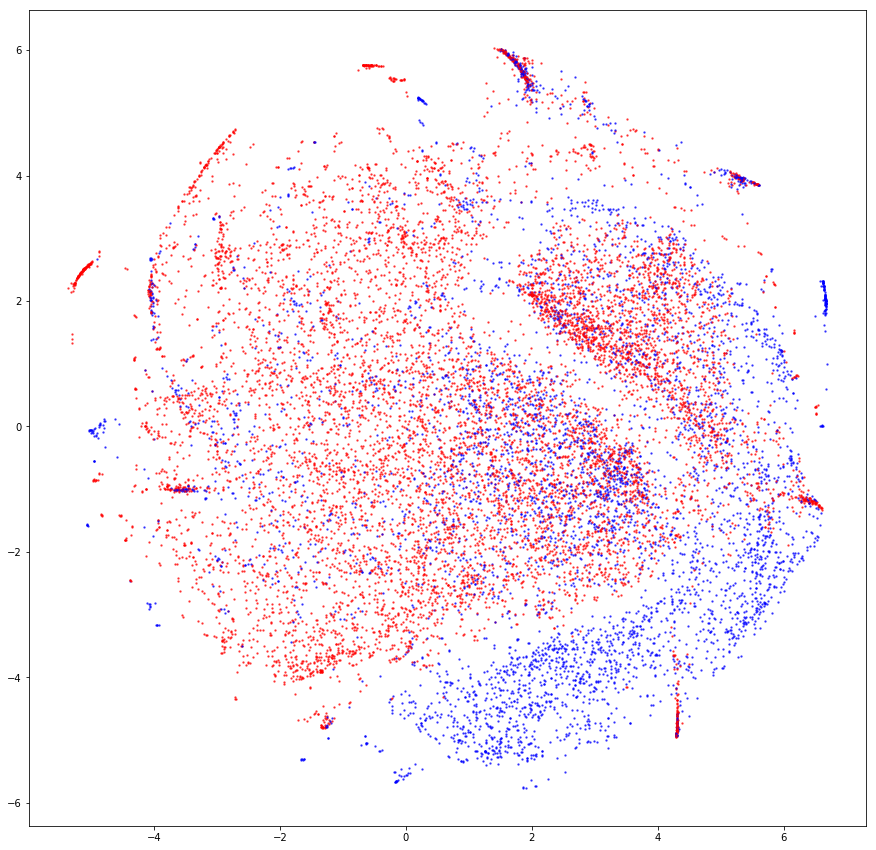

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
for i in range(viz_words):
    if model.wv.index2word[i][-1] == 'N':
        plt.scatter(*embed_tsne[i,:],s=2,alpha=0.6, color='r')
        #plt.annotate(model.wv.index2word[i], (embed_tsne[i,0], embed_tsne[i,1]), alpha=0.6, fontsize=7)
    else:
        plt.scatter(*embed_tsne[i,:],s=2,alpha=0.6,color='b')
        #plt.annotate(model.wv.index2word[i], (embed_tsne[i,0], embed_tsne[i,1]), alpha=0.6, fontsize=7)
plt.savefig("seperate_15000_nolabel.png")

In [48]:
plt.savefig("label.png")

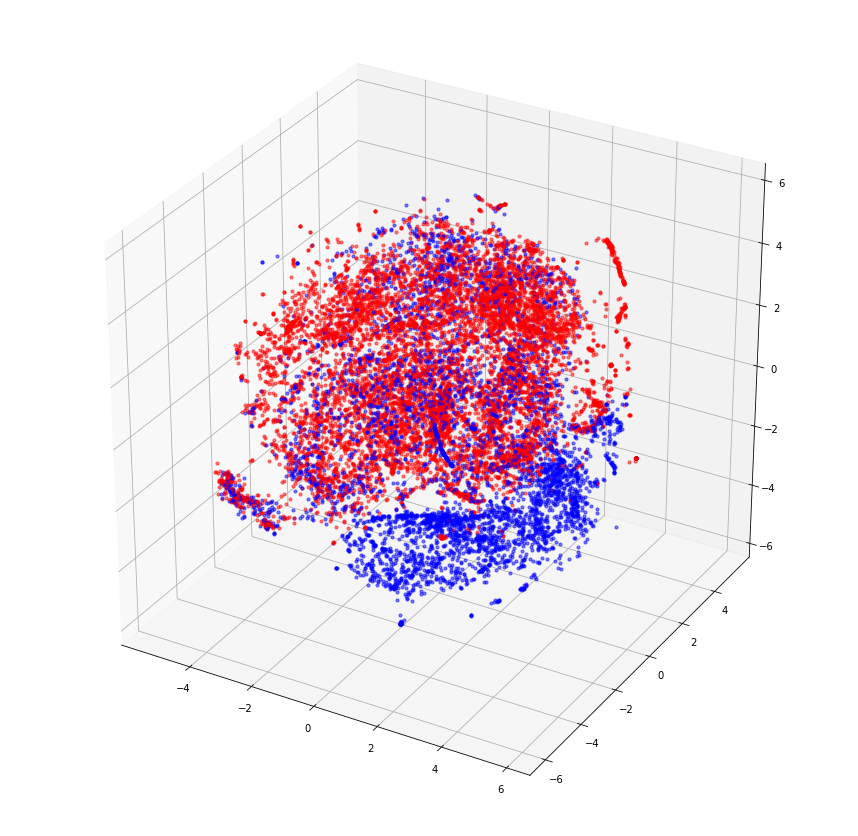

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(viz_words):
    if model.wv.index2word[i][-1]=='N':
        plt.scatter(embed_tsne[i][2], embed_tsne[i][1],zs=embed_tsne[i][0],zdir='z',s=10,c='r',alpha=0.5)
        #plt.annotate(topic_list[i][0],(embed_tsne[i,0], embed_tsne[i,1]),fontsize=7)
    else:
        plt.scatter(embed_tsne[i,2],embed_tsne[i,1],zs=embed_tsne[i,0],s=10,c='b', alpha=0.5)
        #plt.annotate(topic_list[i][0],(embed_tsne[i,0], embed_tsne[i,1]),fontsize=7)